# General

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap



In [2]:
input_file = 'oil_and_gas_dataset.parquet'
df = pd.read_parquet(input_file)

# Analysis

In [3]:
df.head()

,bandeira_revenda_cat,sigla_uf,sigla_uf_nome,id_municipio,id_municipio_nome,produto,unidade_medida,n_estabelecimentos,avg_preco_compra,avg_preco_venda,data
0,White Label,BA,Bahia,2917607,Jaguaquara,Gasolina,R$/litro,5,1.723251,2.030526,2004-05-01
1,Blue Label,SP,São Paulo,3550308,São Paulo,Diesel,R$/litro,33,1.225628,1.397636,2004-05-01
2,Green Label,SP,São Paulo,3550308,São Paulo,Diesel,R$/litro,128,1.224991,1.415282,2004-05-01
3,Green Label,SP,São Paulo,3505708,Barueri,Etanol,R$/litro,5,0.619567,0.856467,2004-05-01
4,White Label,SP,São Paulo,3513009,Cotia,Etanol,R$/litro,21,0.604228,0.804345,2004-05-01


## missing values

In [4]:
df.shape

(556501, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556501 entries, 0 to 556500
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   bandeira_revenda_cat  556501 non-null  object        
 1   sigla_uf              556501 non-null  object        
 2   sigla_uf_nome         556501 non-null  object        
 3   id_municipio          556501 non-null  object        
 4   id_municipio_nome     556501 non-null  object        
 5   produto               556501 non-null  object        
 6   unidade_medida        556498 non-null  object        
 7   n_estabelecimentos    556501 non-null  int64         
 8   avg_preco_compra      331360 non-null  float64       
 9   avg_preco_venda       556501 non-null  float64       
 10  data                  556501 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 46.7+ MB


In [6]:
df.duplicated().any()

False

### missing: unidade_medida

In [7]:
df.unidade_medida.unique()

array(['R$/litro', None], dtype=object)

In [8]:
df[df.unidade_medida.isnull()]

,bandeira_revenda_cat,sigla_uf,sigla_uf_nome,id_municipio,id_municipio_nome,produto,unidade_medida,n_estabelecimentos,avg_preco_compra,avg_preco_venda,data
144602,White Label,MA,Maranhão,2108603,Pinheiro,Gasolina,None,1,NaN,2.81,2010-08-01
185986,White Label,BA,Bahia,2914802,Itabuna,Gasolina,None,1,NaN,2.79,2012-01-01
368999,White Label,RN,Rio Grande do Norte,2408102,Natal,Diesel,None,1,NaN,3.00,2018-07-01


In [9]:
df.avg_preco_venda.describe()

count    556501.000000
mean          3.270554
std           1.390611
min           0.668744
25%           2.205714
50%           2.894286
75%           3.967500
max           8.990000
Name: avg_preco_venda, dtype: float64

unidade_medida not critical for analysis, missing values are not an issue

### missing: avg_preco_compra

In [10]:
df.avg_preco_compra.describe()

count    331360.000000
mean          2.278602
std           0.713028
min           0.413200
25%           1.746553
50%           2.190800
75%           2.649900
max           4.747100
Name: avg_preco_compra, dtype: float64

In [11]:
len(df[df.avg_preco_compra.isnull()])/df.shape[0]

0.4045653107541586

In [12]:
df[df.avg_preco_compra.isnull()]

,bandeira_revenda_cat,sigla_uf,sigla_uf_nome,id_municipio,id_municipio_nome,produto,unidade_medida,n_estabelecimentos,avg_preco_compra,avg_preco_venda,data
33,White Label,SP,São Paulo,3509957,Canas,Etanol,R$/litro,1,NaN,1.024000,2004-05-01
82,Green Label,SP,São Paulo,3541406,Presidente Prudente,Gasolina,R$/litro,3,NaN,1.986333,2004-05-01
84,Green Label,RJ,Rio de Janeiro,3302007,Itaguaí,Etanol,R$/litro,1,NaN,0.999000,2004-05-01
143,Blue Label,MG,Minas Gerais,3128709,Guaxupé,Diesel,R$/litro,1,NaN,1.300000,2004-05-01
219,Blue Label,CE,Ceará,2302800,Canindé,Diesel,R$/litro,1,NaN,1.509000,2004-05-01
...,...,...,...,...,...,...,...,...,...,...,...
556496,Blue Label,MA,Maranhão,2111300,São Luís,Gasolina,R$/litro,4,NaN,5.836667,2024-08-01
556497,Blue Label,PA,Pará,1506807,Santarém,Diesel,R$/litro,6,NaN,6.234545,2024-08-01
556498,Purple Label,SP,São Paulo,3526902,Limeira,Diesel,R$/litro,4,NaN,6.006000,2024-08-01
556499,Purple Label,SP,São Paulo,3518800,Guarulhos,Diesel,R$/litro,1,NaN,6.040000,2024-08-01


In [13]:
df.avg_preco_compra.corr(df.avg_preco_venda )

0.987650200558096

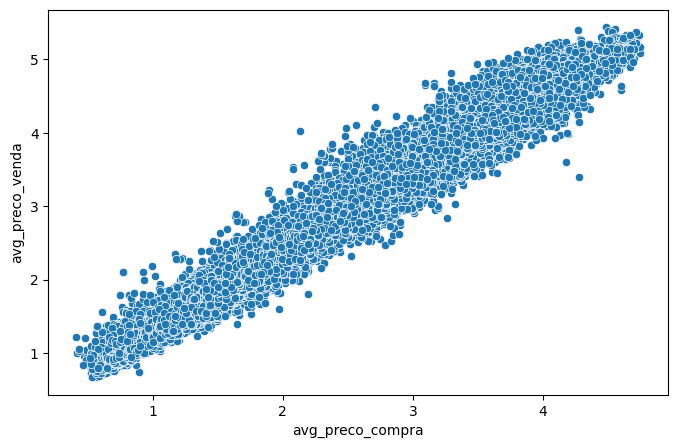

In [14]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='avg_preco_compra', y='avg_preco_venda')
plt.show()

ffill missing data 

In [36]:
df.sort_values(['sigla_uf', 'sigla_uf_nome', 'id_municipio',
       'id_municipio_nome', 'bandeira_revenda_cat','produto',"data"])

,bandeira_revenda_cat,sigla_uf,sigla_uf_nome,id_municipio,id_municipio_nome,produto,unidade_medida,n_estabelecimentos,avg_preco_compra,avg_preco_venda,data,avg_preco_compra_old
67666,Blue Label,AC,Acre,1200013,Acrelândia,Diesel,R$/litro,1,1.87405,2.180000,2008-01-01,1.87405
72631,Blue Label,AC,Acre,1200013,Acrelândia,Diesel,R$/litro,1,1.88100,2.180000,2008-02-01,1.88100
75888,Blue Label,AC,Acre,1200013,Acrelândia,Diesel,R$/litro,1,1.88100,2.180000,2008-03-01,1.88100
83684,Blue Label,AC,Acre,1200013,Acrelândia,Diesel,R$/litro,1,1.88100,2.180000,2008-04-01,1.88100
88931,Blue Label,AC,Acre,1200013,Acrelândia,Diesel,R$/litro,1,1.88100,2.386667,2008-05-01,1.88100
...,...,...,...,...,...,...,...,...,...,...,...,...
207047,White Label,TO,Tocantins,1722107,Xambioá,Etanol,R$/litro,1,NaN,2.299000,2013-02-01,NaN
190828,White Label,TO,Tocantins,1722107,Xambioá,Gasolina,R$/litro,1,NaN,2.940000,2012-07-01,NaN
197780,White Label,TO,Tocantins,1722107,Xambioá,Gasolina,R$/litro,1,NaN,2.940000,2012-08-01,NaN
200933,White Label,TO,Tocantins,1722107,Xambioá,Gasolina,R$/litro,1,NaN,2.899000,2013-01-01,NaN


In [33]:
df['avg_preco_compra_old']=df['avg_preco_compra']

In [34]:
df['avg_preco_compra'] = df.sort_values("data").groupby(['sigla_uf', 'sigla_uf_nome', 'id_municipio',
       'id_municipio_nome', 'bandeira_revenda_cat','produto'],as_index=False).avg_preco_compra.ffill()

In [37]:
df['avg_preco_compra'] = df.sort_values("data").groupby(['sigla_uf', 'sigla_uf_nome', 'id_municipio',
       'id_municipio_nome','produto'],as_index=False).avg_preco_compra.ffill()

In [38]:
len(df[df.avg_preco_compra.isnull()])/df.shape[0]

0.0021832844864609407

In [39]:
# df = df[~df.avg_preco_compra.isnull()]


## Features

### bandeira_revenda_cat

<Axes: >

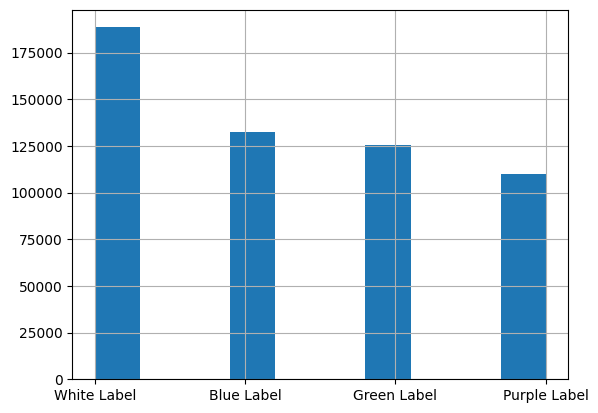

In [40]:
df.bandeira_revenda_cat.hist()

<Axes: title={'center': 'avg_preco_venda'}, xlabel='[bandeira_revenda_cat]'>

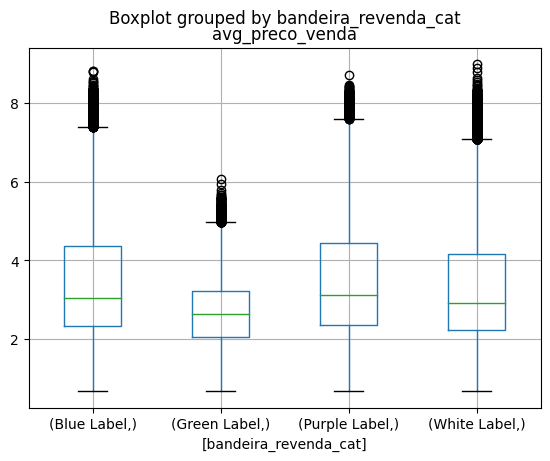

In [41]:
df.boxplot(column=['avg_preco_venda'], by=['bandeira_revenda_cat'])

balanced distribuition among category bandeira revenda

### sigla_uf 

<Axes: >

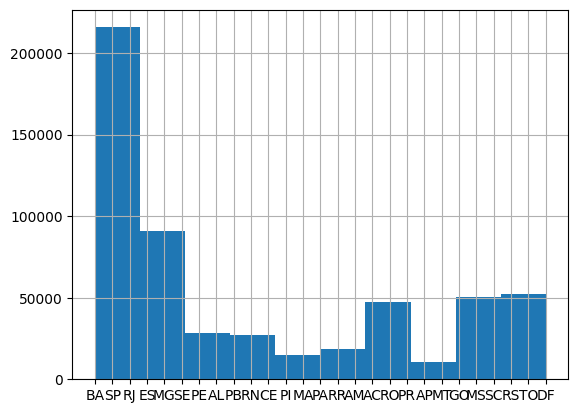

In [42]:
df.sigla_uf.hist()

<Axes: title={'center': 'avg_preco_venda'}, xlabel='[sigla_uf]'>

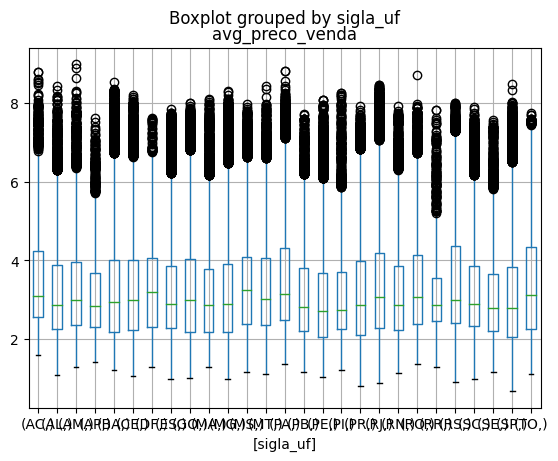

In [43]:
df.boxplot(column=['avg_preco_venda'], by=['sigla_uf'])

 seems uniform, with some states showing more concentrated spending and others more dispersed, but with close medians

### produto

<Axes: >

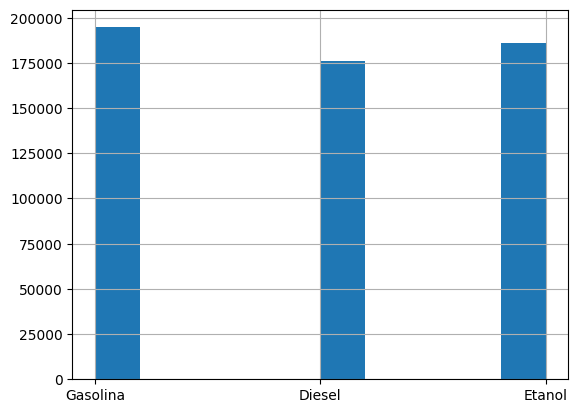

In [44]:
df.produto.hist()

<Axes: title={'center': 'avg_preco_venda'}, xlabel='[produto]'>

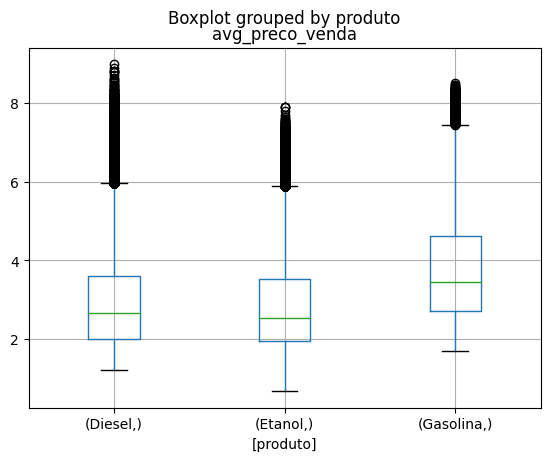

In [45]:
df.boxplot(column=['avg_preco_venda'], by=['produto'])

Ethanol and diesel with similar behavior, but gasolina with higher values

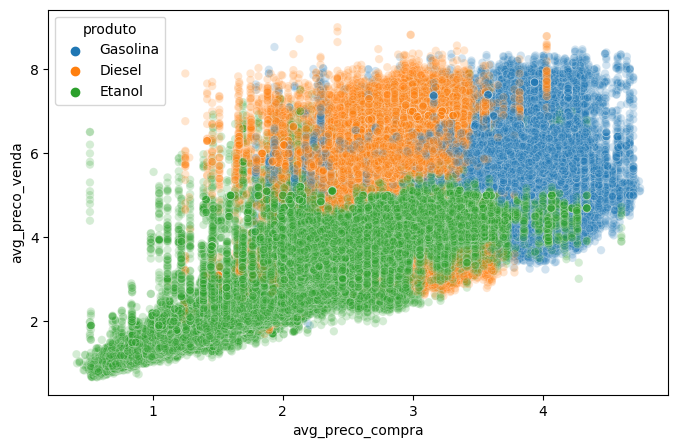

In [46]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='avg_preco_compra', y='avg_preco_venda', hue='produto', alpha = 0.2)
plt.show()

### n_estabelecimentos

In [47]:
df.n_estabelecimentos.describe()

count    556501.000000
mean          6.343187
std          15.529743
min           1.000000
25%           2.000000
50%           3.000000
75%           6.000000
max        1096.000000
Name: n_estabelecimentos, dtype: float64

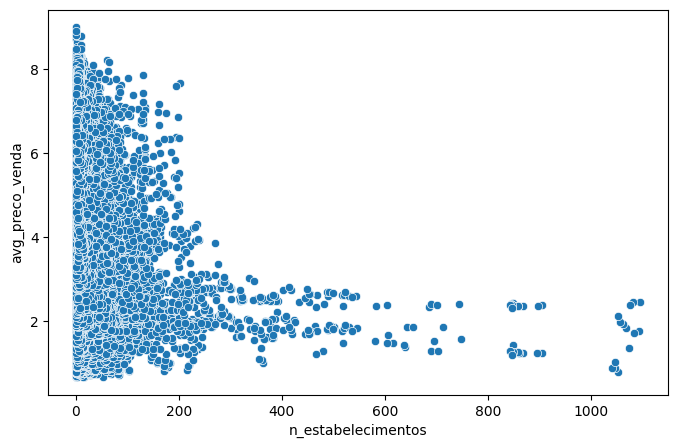

In [48]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='n_estabelecimentos', y='avg_preco_venda')
plt.show()

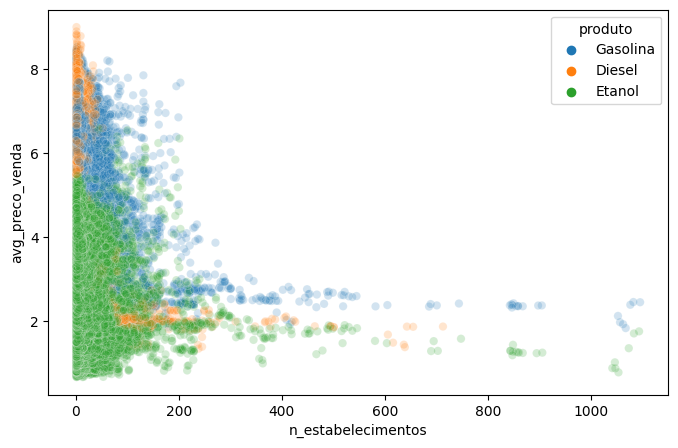

In [49]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='n_estabelecimentos', y='avg_preco_venda', hue="produto", alpha =0.2)
plt.show()

In [50]:
df.n_estabelecimentos.corr(df.avg_preco_venda )

-0.055119201164351136

In [57]:
df.groupby(['id_municipio', 'bandeira_revenda_cat'], as_index=False).agg(
    n_estabelecimentos = ('n_estabelecimentos','mean')
).describe()


,n_estabelecimentos
count,2262.000000
mean,4.836807
std,9.814422
min,1.000000
25%,1.366656
50%,2.499027
75%,5.075000
max,279.958025


In [58]:
 df["market_size_city"] = pd.qcut(df['n_estabelecimentos'], 
                      q=3, 
                      labels=['few', 'avg', 'many'])

<Axes: title={'center': 'avg_preco_venda'}, xlabel='[market_size_city]'>

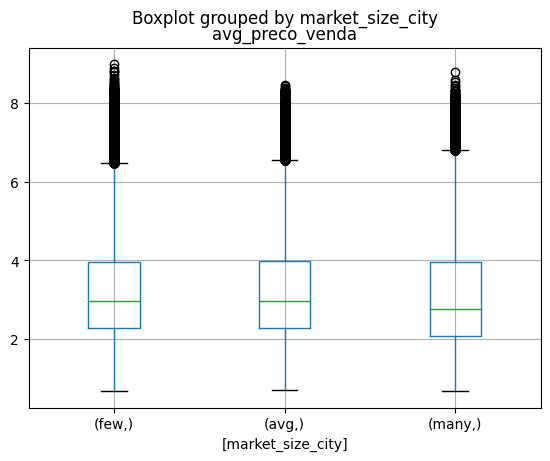

In [59]:
df.boxplot(column=['avg_preco_venda'], by=['market_size_city'])

### Date

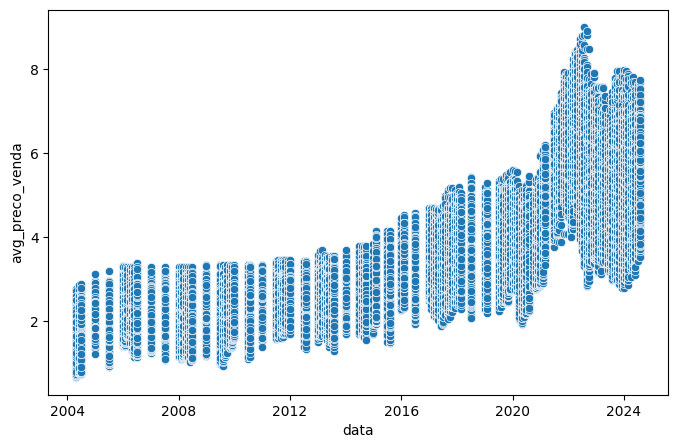

In [60]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='data', y='avg_preco_venda')
plt.show()

In [61]:
df.data.corr(df.avg_preco_venda )

0.8238647272148806

data has a tendency with date

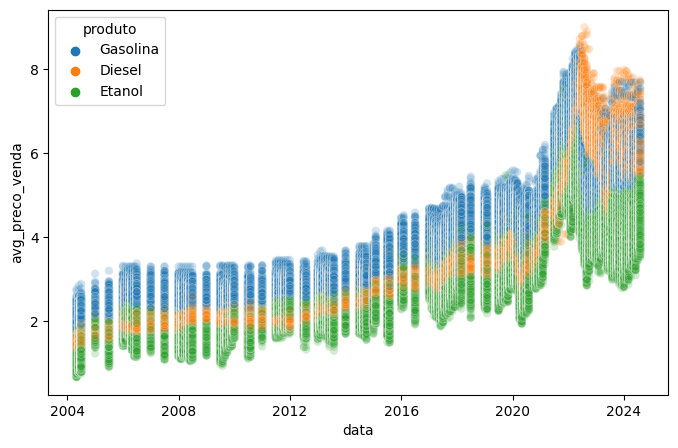

In [63]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='data', y='avg_preco_venda', hue="produto", alpha =0.2)
plt.show()

In [64]:
df['data'] = pd.to_datetime(df['data'])
df['month'] = df['data'].dt.month
df['quarter'] = df['data'].dt.quarter
df['year'] = df['data'].dt.year
# df['day_of_week'] = df['data'].dt.dayofweek
# df['day_of_year'] = df['data'].dt.dayofyear


<Axes: title={'center': 'avg_preco_venda'}, xlabel='[year]'>

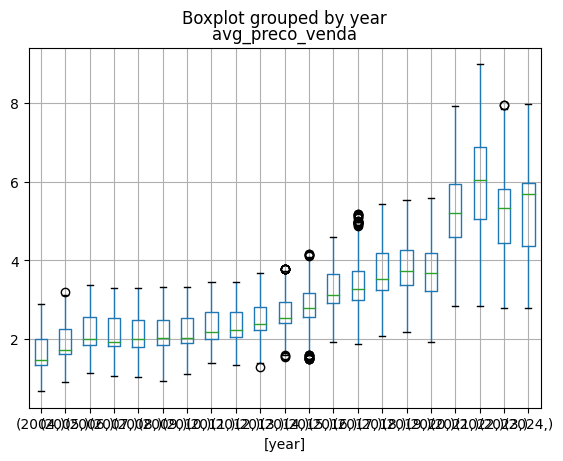

In [65]:
# df.boxplot(column=['avg_preco_venda'], by=['month'])
# df.boxplot(column=['avg_preco_venda'], by=['quarter'])
df.boxplot(column=['avg_preco_venda'], by=['year'])

<Axes: title={'center': 'avg_preco_venda'}, xlabel='[quarter]'>

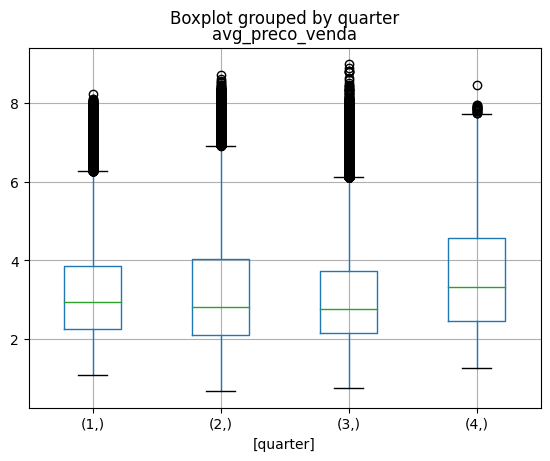

In [66]:
df.boxplot(column=['avg_preco_venda'], by=['quarter'])

In [67]:
df.data.unique()

<DatetimeArray>
['2004-05-01 00:00:00', '2004-06-01 00:00:00', '2004-07-01 00:00:00',
 '2005-01-01 00:00:00', '2005-07-01 00:00:00', '2006-01-01 00:00:00',
 '2006-02-01 00:00:00', '2006-03-01 00:00:00', '2006-04-01 00:00:00',
 '2006-05-01 00:00:00',
 ...
 '2023-11-01 00:00:00', '2023-12-01 00:00:00', '2024-01-01 00:00:00',
 '2024-02-01 00:00:00', '2024-03-01 00:00:00', '2024-04-01 00:00:00',
 '2024-05-01 00:00:00', '2024-06-01 00:00:00', '2024-07-01 00:00:00',
 '2024-08-01 00:00:00']
Length: 137, dtype: datetime64[ns]

In [72]:
split_date = '2024-06-01 00:00:00'

In [73]:
split_date

'2024-06-01 00:00:00'

### preco_compra_volatility

In [74]:
df.columns

Index(['bandeira_revenda_cat', 'sigla_uf', 'sigla_uf_nome', 'id_municipio',
       'id_municipio_nome', 'produto', 'unidade_medida', 'n_estabelecimentos',
       'avg_preco_compra', 'avg_preco_venda', 'data', 'avg_preco_compra_old',
       'market_size_city', 'month', 'quarter', 'year'],
      dtype='object')

In [75]:
df_month = df.groupby(['sigla_uf','bandeira_revenda_cat', 'id_municipio',
        'produto', 'month'], as_index=False).agg(
    num_dias_compra = ('data', 'nunique'),
    avg_preco_compra = ('avg_preco_compra', 'mean')    
       )

In [76]:
df_puchase_pricing = df_month.groupby(['sigla_uf','bandeira_revenda_cat', 'id_municipio',
        'produto'], as_index=False).agg(
    num_meses_compra = ('month', 'nunique'),
    monthly_avg_preco_compra = ('avg_preco_compra', 'mean'),
    monthly_volatility_preco_compra = ('avg_preco_compra', 'std')    
       )
df_puchase_pricing['cv_preco_compra'] = df_puchase_pricing.monthly_volatility_preco_compra/ df_puchase_pricing.monthly_avg_preco_compra

In [77]:
df1 = df.merge(df_puchase_pricing, on = ['sigla_uf','bandeira_revenda_cat', 'id_municipio',
        'produto'], how='left')

C:\Users\caroline.c.barbosa\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


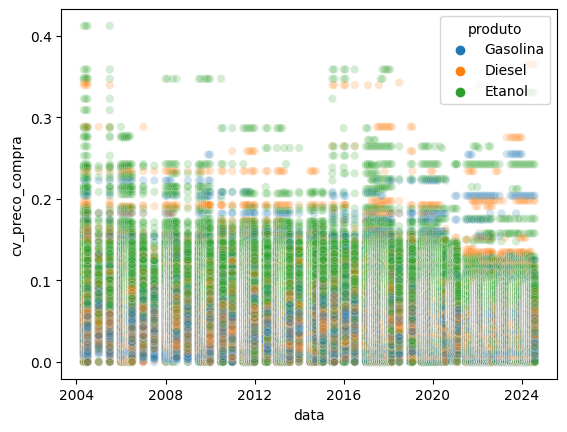

In [78]:
sns.scatterplot(data=df1, x='data', y='cv_preco_compra', hue='produto', alpha=0.2)
plt.show()

C:\Users\caroline.c.barbosa\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


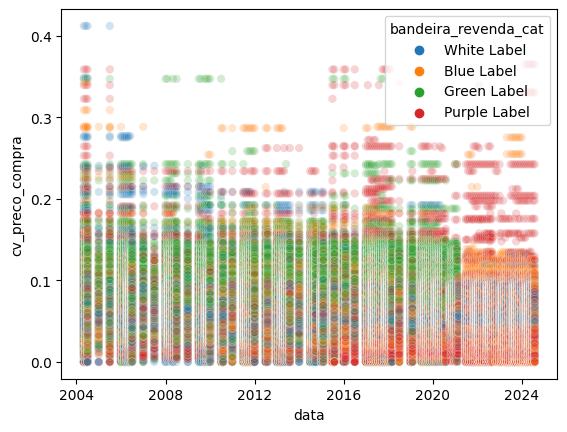

In [79]:
sns.scatterplot(data=df1, x='data', y='cv_preco_compra', hue='bandeira_revenda_cat', alpha=0.2)
plt.show()

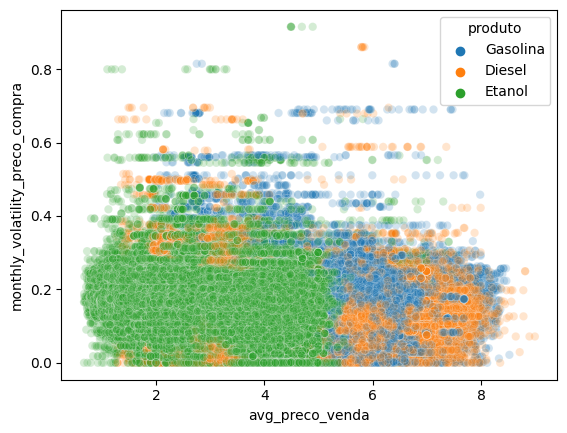

In [80]:
sns.scatterplot(data=df1, x='avg_preco_venda', y='monthly_volatility_preco_compra', hue='produto', alpha=0.2)
plt.show()

## Target

In [81]:
df.avg_preco_venda.describe()

count    556501.000000
mean          3.270554
std           1.390611
min           0.668744
25%           2.205714
50%           2.894286
75%           3.967500
max           8.990000
Name: avg_preco_venda, dtype: float64

In [82]:
## 50% of pricing of prices 1.99<=price<=3.08 --> intervalo interquartil de R$ 1.078


## Correlation

In [83]:
df1.columns

Index(['bandeira_revenda_cat', 'sigla_uf', 'sigla_uf_nome', 'id_municipio',
       'id_municipio_nome', 'produto', 'unidade_medida', 'n_estabelecimentos',
       'avg_preco_compra', 'avg_preco_venda', 'data', 'avg_preco_compra_old',
       'market_size_city', 'month', 'quarter', 'year', 'num_meses_compra',
       'monthly_avg_preco_compra', 'monthly_volatility_preco_compra',
       'cv_preco_compra'],
      dtype='object')

In [84]:
df_dummy = pd.get_dummies(df1, columns=['produto','market_size_city' ])

In [85]:
df_dummy.columns

Index(['bandeira_revenda_cat', 'sigla_uf', 'sigla_uf_nome', 'id_municipio',
       'id_municipio_nome', 'unidade_medida', 'n_estabelecimentos',
       'avg_preco_compra', 'avg_preco_venda', 'data', 'avg_preco_compra_old',
       'month', 'quarter', 'year', 'num_meses_compra',
       'monthly_avg_preco_compra', 'monthly_volatility_preco_compra',
       'cv_preco_compra', 'produto_Diesel', 'produto_Etanol',
       'produto_Gasolina', 'market_size_city_few', 'market_size_city_avg',
       'market_size_city_many'],
      dtype='object')

In [86]:
interesting_columns = ['n_estabelecimentos','avg_preco_compra',  'data', 'month', 'quarter',
       'year', 'monthly_avg_preco_compra',
       'monthly_volatility_preco_compra', 'cv_preco_compra', 'produto_Diesel',
       'produto_Etanol', 'produto_Gasolina', 'market_size_city_few',
       'market_size_city_avg', 'market_size_city_many', 'avg_preco_venda',]


In [87]:
corr_matrix = df_dummy[interesting_columns].corr()

In [88]:
corr_matrix

,n_estabelecimentos,avg_preco_compra,data,month,quarter,year,monthly_avg_preco_compra,monthly_volatility_preco_compra,cv_preco_compra,produto_Diesel,produto_Etanol,produto_Gasolina,market_size_city_few,market_size_city_avg,market_size_city_many,avg_preco_venda
n_estabelecimentos,1.000000,-0.043720,-0.066526,-0.000023,0.001271,-0.066833,0.047362,0.074054,0.047244,-0.054219,0.021139,0.031949,-0.264902,-0.102760,0.384870,-0.055119
avg_preco_compra,-0.043720,1.000000,0.745102,0.051529,0.029866,0.746067,0.623077,0.181963,-0.176797,-0.144518,-0.331159,0.468330,-0.018613,0.043603,-0.022980,0.798507
data,-0.066526,0.745102,1.000000,0.119534,0.094655,0.998851,0.176835,0.018592,-0.072677,-0.028678,0.010578,0.017495,0.011068,0.035819,-0.047100,0.823865
month,-0.000023,0.051529,0.119534,1.000000,0.971080,0.071828,0.021106,0.001747,-0.009212,-0.002720,0.001679,0.000991,-0.005162,0.002108,0.003455,0.074745
quarter,0.001271,0.029866,0.094655,0.971080,1.000000,0.048234,0.015866,0.001695,-0.006608,-0.002192,0.001565,0.000589,-0.006314,0.001648,0.005142,0.048437
year,-0.066833,0.746067,0.998851,0.071828,0.048234,1.000000,0.176636,0.018589,-0.072574,-0.028679,0.010546,0.017528,0.011367,0.035884,-0.047485,0.824076
monthly_avg_preco_compra,0.047362,0.623077,0.176835,0.021106,0.015866,0.176636,1.000000,0.311879,-0.264495,-0.237697,-0.517239,0.743211,-0.098412,0.010740,0.094798,0.421669
monthly_volatility_preco_compra,0.074054,0.181963,0.018592,0.001747,0.001695,0.018589,0.311879,1.000000,0.806596,-0.256179,0.082966,0.167691,-0.109096,0.011673,0.105308,0.031180
cv_preco_compra,0.047244,-0.176797,-0.072677,-0.009212,-0.006608,-0.072574,-0.264495,0.806596,1.000000,-0.158515,0.410415,-0.251321,-0.056124,0.005489,0.054683,-0.209888
produto_Diesel,-0.054219,-0.144518,-0.028678,-0.002720,-0.002192,-0.028679,-0.237697,-0.256179,-0.158515,1.000000,-0.481466,-0.498688,0.070377,0.011862,-0.087058,-0.054001


<Axes: >

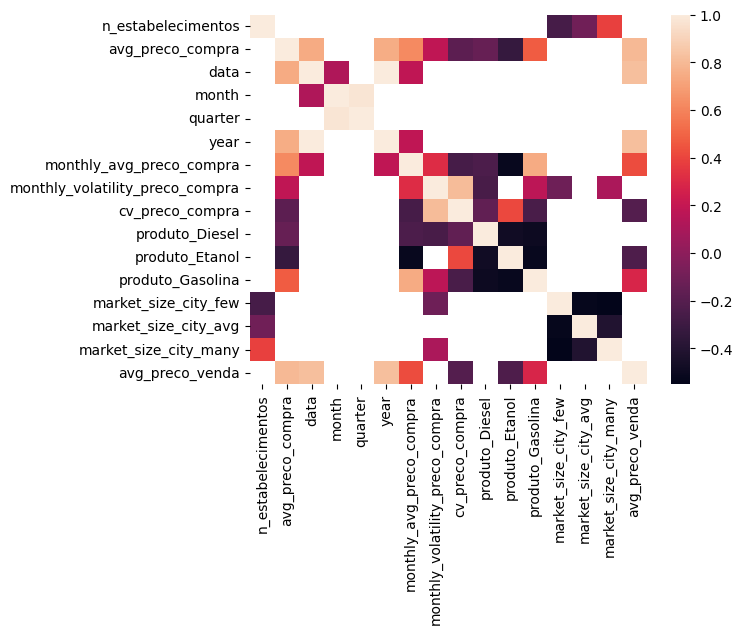

In [89]:
sns.heatmap(corr_matrix[(abs(corr_matrix)>0.1)  ])

In [90]:
relevant_columns = ['avg_preco_compra',  'data', 'monthly_avg_preco_compra',
        'produto_Diesel',
       'produto_Etanol', 'produto_Gasolina', 'avg_preco_venda']
df_dummy = df_dummy[relevant_columns]

# Preparation

In [91]:
df_dummy = df_dummy[~df_dummy.avg_preco_compra.isnull()]

df_dummy['day'] = df_dummy['data'].dt.day #pd.to_datetime(df_dummy['data'])
df_dummy['month'] = df_dummy['data'].dt.month
df_dummy['year'] = df_dummy['data'].dt.year
# relevant_columns.append('day')
# relevant_columns.append('month')
relevant_columns.append('year')
relevant_columns.remove("data")

### train test separation 

In [92]:
target = 'avg_preco_venda'

In [93]:
relevant_columns.remove(target)

In [94]:
relevant_columns

['avg_preco_compra',
 'monthly_avg_preco_compra',
 'produto_Diesel',
 'produto_Etanol',
 'produto_Gasolina',
 'year']

In [95]:
df_dummy.shape

(555286, 10)

In [96]:
df_train = df_dummy[df_dummy.data<= split_date]
df_test = df_dummy[df_dummy.data> split_date]

In [97]:
X_train = df_train[relevant_columns]
y_train = df_train[target]
X_test = df_test[relevant_columns]
y_test = df_test[target]

In [99]:
print(X_train.shape)
print(len(y_train))
print(X_test.shape)
print(len(y_test))


(550327, 6)
550327
(4959, 6)
4959


# Modelling

In [100]:

models = {
    'LinearRegression':
    {"model": LinearRegression(),
     "X_train":  X_train,
     "y_train":  y_train
     },
    'PolynomialRegression':
    {"model": make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
     "X_train":  X_train,
     "y_train":  y_train
     },
    'Ridge':
    {"model": Ridge(),
     "X_train":  X_train,
     "y_train":  y_train
     },
    'DecisionTree':
    {"model": DecisionTreeRegressor(),
     "X_train":  X_train,
     "y_train":  y_train
     },
    'RandomForest':
    {"model": RandomForestRegressor(),
     "X_train":  X_train,
     "y_train":  y_train
     },
    'GradientBoostingRegressor':
    {"model": GradientBoostingRegressor(loss= "squared_error"),
     "X_train":  X_train,
     "y_train":  y_train
     }
}

In [101]:
def getCrossValMetrics(score):
    mae = -score['test_neg_mean_absolute_error'].mean()
    rmse = -score['test_neg_root_mean_squared_error'].mean()
    r2 = score['test_r2'].mean()
    #     mape = -crossValScore['test_neg_mean_absolute_percentage_error']
    return mae, rmse, r2

In [102]:
def run_Reg_models(model_name):
    model = models[model_name]

    minmax_scaler = MinMaxScaler()
    X_train_norm = minmax_scaler.fit_transform(model["X_train"])

    y= model["y_train"].to_numpy().ravel()

    tscv = TimeSeriesSplit(n_splits=5)
    crossValScore = cross_validate(model["model"],
                                   X_train_norm,
                                   y,
                                   cv=tscv,
                                   scoring=["neg_mean_absolute_error",
                                            'neg_root_mean_squared_error',
                                            "r2",
                                            "neg_mean_absolute_percentage_error"
                                            ])

    mae, rmse, r2 = getCrossValMetrics(crossValScore)
    results[model_name] = {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "features": list(model["X_train"].columns)}

In [103]:
results = {}

for model_name in models.keys():
    print(f"Initializing model {model_name}...")
    run_Reg_models(model_name)
    print(f"Model {model_name} executed successfully...")

Initializing model LinearRegression...
Model LinearRegression executed successfully...
Initializing model PolynomialRegression...
Model PolynomialRegression executed successfully...
Initializing model Ridge...
Model Ridge executed successfully...
Initializing model DecisionTree...
Model DecisionTree executed successfully...
Initializing model RandomForest...
Model RandomForest executed successfully...
Initializing model GradientBoostingRegressor...
Model GradientBoostingRegressor executed successfully...


In [104]:
df_results = pd.DataFrame(results).T
df_results=df_results.reset_index().rename(columns={"index":"model"})

df_results.sort_values("RMSE")

,model,MAE,RMSE,R2,features
4,RandomForest,0.350275,0.481361,0.542406,"[avg_preco_compra, monthly_avg_preco_compra, p..."
5,GradientBoostingRegressor,0.350546,0.490413,0.522798,"[avg_preco_compra, monthly_avg_preco_compra, p..."
1,PolynomialRegression,0.36346,0.501751,0.496054,"[avg_preco_compra, monthly_avg_preco_compra, p..."
3,DecisionTree,0.37123,0.502815,0.499939,"[avg_preco_compra, monthly_avg_preco_compra, p..."
2,Ridge,0.459376,0.617222,0.205305,"[avg_preco_compra, monthly_avg_preco_compra, p..."
0,LinearRegression,0.459347,0.61729,0.205161,"[avg_preco_compra, monthly_avg_preco_compra, p..."


In [105]:
def plot_model_predictions(y_test, y_pred, title="Model Predictions"):

    sns.relplot(x=y_test, 
                y=y_pred, 
                kind="scatter")
    
    plt.title(title)
    plt.xlabel("actual")
    plt.ylabel("pred")
    plt.show()

In [106]:
df_results = df_results.sort_values("RMSE", ascending=True).reset_index(drop=True)
# df_results[0]

In [107]:
df_results[['model',	'MAE',	'RMSE',	'R2']]

,model,MAE,RMSE,R2
0,RandomForest,0.350275,0.481361,0.542406
1,GradientBoostingRegressor,0.350546,0.490413,0.522798
2,PolynomialRegression,0.36346,0.501751,0.496054
3,DecisionTree,0.37123,0.502815,0.499939
4,Ridge,0.459376,0.617222,0.205305
5,LinearRegression,0.459347,0.61729,0.205161


In [108]:
#model selection
model_name = df_results.loc[0,'model']
print(model_name)

RandomForest


# Evaluating

In [109]:
# def plot_prediction(model_name, X_test, y_test):
model = models[model_name]
minmax_scaler = MinMaxScaler()
X_train_norm = minmax_scaler.fit_transform(model["X_train"])
y= model["y_train"].to_numpy().ravel()

md = model["model"]
md.fit(model["X_train"], y )

RandomForestRegressor()

In [110]:
cols = df_results[df_results.model==model_name].features.iloc[0]

In [111]:
X_test_rf = X_test[cols]

y_pred = md.predict(X_test_rf)

In [112]:
df_test = X_test.copy()

In [113]:
df_test['y_test']=y_test

In [114]:
df_test['y_pred']=y_pred

In [115]:
df_test['MAE'] = np.abs(df_test['y_test'] - df_test['y_pred'])
df_test['MSE'] = (df_test['y_test'] - df_test['y_pred'])**2
# df_test['RMSE'] = np.sqrt(mean_squared_error(df_test['y_test'], df_test['y_pred']))
# mean_absolute_error, mean_squared_error,

In [116]:
df_test['produto']=df_test.apply(lambda x:  x['produto_Diesel'] * "Diesel" + x['produto_Etanol'] * "Etanol" + "Gasolina"* x['produto_Gasolina'] ,axis=1)


In [117]:
RMSE_test = np.sqrt(np.mean(df_test['MSE']))


In [118]:
print('RMSE_test: ',RMSE_test)

RMSE_test:  0.32323537067522046


In [120]:
df_test.groupby('produto', as_index=False).agg({"MAE":"mean",
                                           'MSE':lambda x: np.sqrt(np.mean(x)) ,
                                           "avg_preco_compra": "count"
                                         }).rename(columns={"MSE":"RMSE"}).sort_values("RMSE").rename(columns={"avg_preco_compra": "num_preco_compra"})

,produto,MAE,RMSE,num_preco_compra
0,Diesel,0.112927,0.160831,1450
2,Gasolina,0.309998,0.342530,1801
1,Etanol,0.357568,0.397083,1708


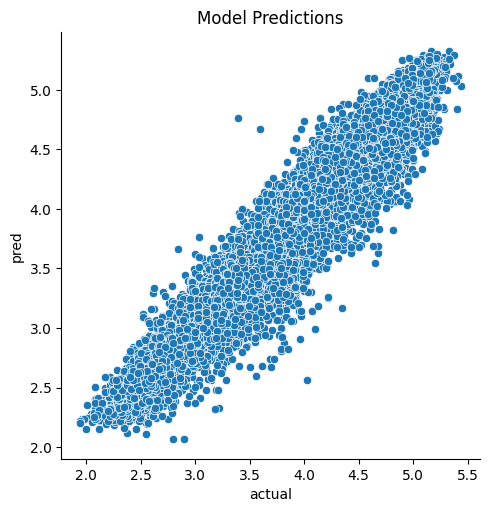

In [88]:
plot_model_predictions(df_test.y_test, df_test.y_pred, title="Model Predictions")

# explainability

In [124]:
importances = md.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


In [125]:
feature_importance_df

,Feature,Importance
5,year,0.646265
0,avg_preco_compra,0.277314
3,produto_Etanol,0.049398
1,monthly_avg_preco_compra,0.018493
4,produto_Gasolina,0.006258
2,produto_Diesel,0.002272


In [ ]:
import shap

# Create a SHAP explainer and calculate SHAP values
explainer = shap.TreeExplainer(md)
shap_values = explainer.shap_values(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)


# Key insights: 

## Model selection

### Generalization

    The RMSE on the test set, 0.1627, is higher than the RMSE on the validation set, 0.1090. This gap suggests the model performs slightly better on the validation data than on new data, indicating some overfitting, but not that high in order to worry.
    The model may be capturing noise in the training data, so selection of a regularization application to the model could benefit improve generalization.

### Performance by Product

    Diesel has the lowest error (MAE: 0.1082, RMSE: 0.1471), indicating the model predicts Diesel prices better than for Gasolina and Ethanol.
    These have higher errors, with similar MAE and RMSE values (0.1304 and 0.1667 for Gasolina, 0.1318 and 0.1706 for Etanol). Thisindicates that prices for Diesel are easier for the model to capture, possibly due to less volatility or fewer influencing factors in Diesel prices compared to Gasolina and Etanol.Overall, Diesel predictions are strong, but there is an opportunity to enhance predictions for Gasolina and Etanol through feature engineering or product-specific models.

### Areas for Improvement

- Regularization: Adding a bit more regularization (e.g., slightly adjusting Ridge or exploring Lasso) might improve generalization by reducing overfitting to the training data.
    
- Additional Features: Consider adding interaction terms, regional demand factors, or other market indicators that might uniquely impact Gasolina and Etanol prices.

- Segmented Modeling: Creating separate models for each product could improve accuracy, as it would allow each model to capture product-specific price dynamics. For instance, a dedicated model for Gasolina might focus on additional seasonal or competitive factors that impact Gasolina more than Diesel.

## Model explainability and business insights

### Purchase Price driving the sellling price

Coefficient of avg_preco_compra: 1.021 – This indicates that for each dollar/real increase in avg_preco_compra, the avg_preco_venda increases by approximately 1.02 (dollars/reais). 
* Creating a monitoring system for the oil purchase price seems crucial, as price fluctuations are essential to defining the best selling precification.
* Negotiating better purchase terms or securing currency advantages on contracts can reduce exposure to fluctuations in purchase costs, helping to maintain stable prices for customers.

### Product-Level Pricing Differences

produto Coefficients:
- Diesel: -0.061 – Diesel has a slightly lower selling price compared to other products.
- Gasolina: 0.060 – Gasoline has a higher selling price adjustment, likely due to higher demand or processing refining which increase its value.
- Etanol: 0.0009 – Ethanol has minimal price adjustment factor.
Insight:
* As each product has an unique price dynamic, implementing differentiated pricing strategies whan purchasing and selling for each product can improve profitability, as each product has its' specific market demand.
* Prioritizing marketing and promotion on Gasolina, which has the highest price elasticity. Customers may be less price-sensitive.

### Yearly trend 

Coefficient of year: 0.0117 – This positive coefficient indicates that prices trend upward year-over-year, likely reflecting inflation or increased demand.
* REview long term pricing strategies, planning for annual price increases aligned with inflation. This yearly trend can aid in budgeting and forecasting for future periods.



